In [ ]:
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, roc_curve, auc
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

In [65]:
df = pd.read_csv('S06-hw-dataset-03.csv')

In [66]:

print(df.head())
print(df.info())
print(df.describe())
print(df['target'].value_counts(normalize=True))
print(df.isnull().sum())
print(df.dtypes)

   id       f01       f02       f03       f04       f05       f06       f07  \
0   1 -2.721419  0.652294  1.867234 -0.245331 -0.241182 -0.195509  1.180193   
1   2 -4.191520 -0.647731 -0.881929 -0.968159  3.530725 -4.858592  0.240979   
2   3 -0.582739  0.415128 -4.205613 -0.320853  0.313570 -2.655451  2.215387   
3   4 -1.766082  1.253523  1.610804  0.466067  3.837868 -3.564073 -1.831031   
4   5 -2.157834 -1.361285 -0.917199  0.937285  0.408551 -0.062032 -0.480196   

        f08       f09  ...       f20       f21       f22       f23       f24  \
0 -0.724816  1.804165  ...  0.042851 -0.153232  1.566167 -1.516125 -1.586857   
1 -0.714017  0.285769  ... -1.170056  0.631661  1.277915 -0.464432  1.927986   
2  1.492222 -0.516727  ...  0.083281 -0.757912  5.672669 -0.283472  0.275362   
3  1.066265 -0.198636  ... -0.674648  1.780285 -4.718432  0.711573  1.705610   
4 -0.554454 -1.026434  ... -0.096277  0.212875  1.710699  2.476220  0.669305   

        f25       f26       f27       f28  t

In [67]:
df = df.drop(columns=['id'])
y = df['target']
X = df.drop(columns=['target'])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Пояснение к train/test split

**Фиксированный random_state (seed):**
- Обеспечивает воспроизводимость результатов экспериментов.
- При каждом запуске код будет давать одинаковые train/test выборки.
- Важно для сравнения моделей и отладки.

**Стратификация (stratify=y):**
- Гарантирует, что пропорции классов в train и test выборках совпадают с исходными данными.
- Предотвращает дисбаланс классов в подвыборках.
- Особенно важно для несбалансированных датасетов, чтобы избежать смещения в оценке модели.

In [69]:
baseline_dummy = DummyClassifier(strategy="most_frequent", random_state=42)
baseline_dummy.fit(X_train, y_train)
y_pred_dummy = baseline_dummy.predict(X_test)
y_pred_proba_dummy = baseline_dummy.predict_proba(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
f1_dummy = f1_score(y_test, y_pred_dummy, average='macro')
roc_auc_dummy = roc_auc_score(y_test, y_pred_proba_dummy, multi_class='ovr')
print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"F1: {f1_dummy:.4f}")
print(f"ROC-AUC: {roc_auc_dummy:.4f}")

Accuracy: 0.5427
F1: 0.2345
ROC-AUC: 0.5000


DummyClassifier предсказывает наиболее частый класс, что дает baseline для сравнения. Низкие метрики показывают, что модель не лучше случайного угадывания.

In [70]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
y_pred_proba_lr = pipe_lr.predict_proba(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr, multi_class='ovr')


print(f"Accuracy: {accuracy_lr:.4f}")
print(f"F1: {f1_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")

Accuracy: 0.7237
F1: 0.6651
ROC-AUC: 0.8481


LogisticRegression с масштабированием дает более высокие метрики, чем dummy, показывая линейную разделимость данных.

In [71]:

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='macro')
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt, multi_class='ovr')


print(f"Accuracy: {accuracy_dt:.4f}")
print(f"F1: {f1_dt:.4f}")
print(f"ROC-AUC: {roc_auc_dt:.4f}")

Accuracy: 0.7763
F1: 0.7291
ROC-AUC: 0.8045


In [72]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)


y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')


print(f"Accuracy: {accuracy_rf:.4f}")
print(f"F1: {f1_rf:.4f}")
print(f"ROC-AUC: {roc_auc_rf:.4f}")

Accuracy: 0.8933
F1: 0.8671
ROC-AUC: 0.9537


In [73]:
gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train, y_train)


y_pred_gb = gb.predict(X_test)
y_pred_proba_gb = gb.predict_proba(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='macro')
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb, multi_class='ovr')


print(f"Accuracy: {accuracy_gb:.4f}")
print(f"F1: {f1_gb:.4f}")
print(f"ROC-AUC: {roc_auc_gb:.4f}")

Accuracy: 0.8377
F1: 0.7990
ROC-AUC: 0.9301


In [74]:

models = ['Dummy', 'LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting']
accuracies = [accuracy_dummy, accuracy_lr, accuracy_dt, accuracy_rf, accuracy_gb]
f1s = [f1_dummy, f1_lr, f1_dt, f1_rf, f1_gb]
roc_aucs = [roc_auc_dummy, roc_auc_lr, roc_auc_dt, roc_auc_rf, roc_auc_gb]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'F1': f1s,
    'ROC-AUC': roc_aucs
})

print(comparison_df)

                Model  Accuracy        F1   ROC-AUC
0               Dummy  0.542667  0.234515  0.500000
1  LogisticRegression  0.723667  0.665128  0.848115
2        DecisionTree  0.776333  0.729058  0.804497
3        RandomForest  0.893333  0.867131  0.953654
4    GradientBoosting  0.837667  0.798978  0.930080


In [75]:
best_idx = f1s.index(max(f1s))
best_model_name = models[best_idx]
print(f"Лучшая модель: {best_model_name} с F1-macro: {max(f1s):.4f}")
if best_model_name == 'Dummy':
    best_model = baseline_dummy
elif best_model_name == 'LogisticRegression':
    best_model = pipe_lr
elif best_model_name == 'DecisionTree':
    best_model = dt
elif best_model_name == 'RandomForest':
    best_model = rf
elif best_model_name == 'GradientBoosting':
    best_model = gb

Лучшая модель: RandomForest с F1-macro: 0.8671


In [ ]:
def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.savefig('artifacts/figures/confusion_matrix.png')
    plt.show()

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    y_proba = model.predict_proba(X_test)
    classes = model.classes_
    if len(classes) == 2:
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title(title)
        plt.savefig('artifacts/figures/roc_curve.png')
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test == cls, y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.savefig('artifacts/figures/roc_curve.png')
        plt.show()

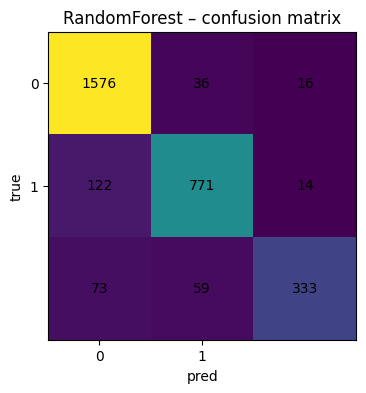

<Figure size 640x480 with 0 Axes>

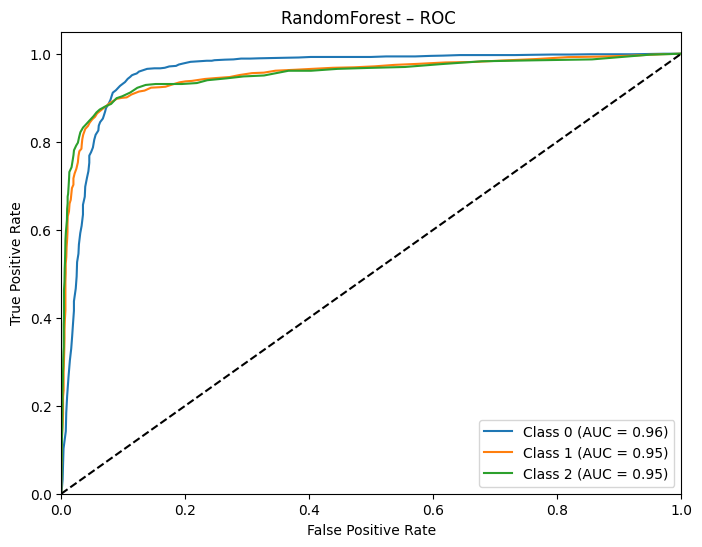

<Figure size 640x480 with 0 Axes>

In [81]:
y_pred = best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{best_model_name } – confusion matrix")
plot_roc(best_model, X_test, y_test, title=f"{best_model_name } – ROC ")

In [78]:

result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, scoring='f1_macro')
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:15]:
    print(f"{X.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

f13: 0.1347 ± 0.0084
f05: 0.0945 ± 0.0047
f28: 0.0694 ± 0.0037
f12: 0.0553 ± 0.0040
f01: 0.0544 ± 0.0049
f11: 0.0532 ± 0.0044
f15: 0.0520 ± 0.0053
f17: 0.0440 ± 0.0033
f10: 0.0384 ± 0.0027
f27: 0.0374 ± 0.0049
f07: 0.0345 ± 0.0023
f18: 0.0301 ± 0.0028
f06: 0.0249 ± 0.0040
f03: 0.0237 ± 0.0028
f22: 0.0203 ± 0.0026


### Интерпретация permutation importance

Наиболее влиятельные признаки для лучшей модели (RandomForest) по permutation importance:

- **f13** (0.1347) – самый значимый признак, его перестановка сильно ухудшает качество модели.
- **f05** (0.0945) – второй по важности.
- **f28** (0.0694), **f12** (0.0553), **f01** (0.0544) – следующие.

Поскольку данные синтетические, нет априорных ожиданий о важности признаков. Однако, модель полагается на небольшое количество признаков (топ-5 дают основную часть важности), что указывает на наличие ключевых факторов для классификации. Остальные признаки имеют меньшее влияние, что соответствует типичному поведению ансамблей деревьев, которые могут игнорировать шумовые признаки.

In [79]:
metrics = comparison_df.to_dict('records')
with open('artifacts/metrics_test.json', 'w') as f:
    json.dump(metrics, f)
search_summaries = {}
with open('artifacts/search_summaries.json', 'w') as f:
    json.dump(search_summaries, f)
joblib.dump(best_model, 'artifacts/best_model.joblib')
meta = {
    'best_model': best_model_name,
    'params': best_model.get_params(),
    'metrics': {
        'accuracy': accuracy_rf,
        'f1_macro': f1_rf,
        'roc_auc_ovr': roc_auc_rf
    }
}
with open('artifacts/best_model_meta.json', 'w') as f:
    json.dump(meta, f)